The goal of this notebook is to compare LCEGP with fitting independent SingleTaskGP
over each alternative.

We will use a 2D test function as the underlying true function.

The metric for comparison is the mean squared error of the predictive mean.

The experiments here do not show any significant difference between the two models.
I would've expected LCEGP to be superior.

This analysis is purely based on the posterior mean. This may be the issue here. The
SingleTaskGP learns the posterior mean as good as the LCEGP. However, it does not learn
of any correlation structure between the alternatives.

In [1]:
from typing import Tuple

import torch
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.utils.transforms import unnormalize
from botorch.test_functions import Branin, Rosenbrock, SyntheticTestFunction
from gpytorch import ExactMarginalLogLikelihood
from torch import Tensor

%matplotlib inline
import matplotlib.pyplot as plt

from contextual_rs.lce_gp import LCEGP

In [2]:
def gen_data_fit_gp(
    num_train: int,
    num_categories: int,
    test_function: SyntheticTestFunction,
    options: dict = None
) -> Tuple[SingleTaskGP, LCEGP]:
    r"""
    Generates `num_train` random training locations for each of the
    `num_categories` categories, which are spaced evenly in [0, 1].
    The training data is then `unnormalize`d and evaluated on the
    given `test_function`.
    The training data is used to fit a batch `SingleTaskGP` model
    and an `LCEGP` model. Fitted models are returned.
    """
    options = options or dict()
    cat_X = torch.linspace(0, 1, num_categories).view(-1, 1, 1)
    cont_X = torch.rand(num_categories, num_train, 1)

    def normalized_eval(X: Tensor) -> Tensor:
        return test_function(unnormalize(X, test_function.bounds))

    train_X = torch.cat(
        [cat_X.expand(-1, num_train, -1), cont_X], dim=-1
    )
    train_Y = normalized_eval(train_X).view(num_categories, num_train, 1)

    # This standardizes each category independently
    transform = Standardize(m=1, batch_shape=torch.Size([num_categories]))
    train_Y, _ = transform(train_Y)

    # This one applies Standardize on all observations at once
    # transform = Standardize(m=1)
    # train_Y, _ = transform(train_Y.view(-1, 1))
    # train_Y = train_Y.view(num_categories, num_train, 1)

    stgp = SingleTaskGP(
        train_X=train_X[..., 1:],
        train_Y=train_Y,
    )
    mll = ExactMarginalLogLikelihood(stgp.likelihood, stgp)
    fit_gpytorch_model(mll)

    # Scale up the categorical entries to be integers
    train_X[..., 0] = (train_X[..., 0] / cat_X[1].view(1)).round()

    lcegp = LCEGP(
        train_X=train_X.view(-1, 2),
        train_Y=train_Y.view(-1, 1),
        categorical_cols=[0],
        embs_dim_list=options.get("embds_dim_list", [2]),
    )
    mll = ExactMarginalLogLikelihood(lcegp.likelihood, lcegp)
    fit_gpytorch_model(mll)

    return stgp, lcegp


def calculate_mse(
    num_test: int,
    num_categories: int,
    test_function: SyntheticTestFunction,
    stgp: SingleTaskGP,
    lcegp: LCEGP,
) -> Tuple[Tensor, Tensor]:
    r"""
    Calculates the mean squared error of the predictive mean for the two
    given models.
    """
    cat_X = torch.linspace(0, 1, num_categories).view(-1, 1, 1)
    cont_X = torch.linspace(0, 1, num_test).view(-1, 1)

    combined_X = torch.cat(
        [
            cat_X.expand(-1, num_test, -1), cont_X.expand(num_categories, -1, -1)
        ], dim=-1
    )

    true_values = test_function.evaluate_true(combined_X)
    stgp_values = stgp.posterior(cont_X).mean.squeeze(-1)
    # scale categorical entries to be integers
    combined_X[..., 0] = (combined_X[..., 0] / cat_X[1].view(1)).round()
    lcegp_values = lcegp.posterior(combined_X).mean.squeeze(-1)

    stgp_mse = (stgp_values - true_values).pow(2).mean(dim=-1)
    lcegp_mse = (lcegp_values - true_values).pow(2).mean(dim=-1)
    return stgp_mse, lcegp_mse


def fit_and_get_mse(
    num_train: int,
    num_test: int,
    num_categories: int,
    test_function: SyntheticTestFunction,
    options: dict = None
) -> Tuple[Tensor, Tensor]:
    r"""Combines the above two functions"""
    stgp, lcegp = gen_data_fit_gp(
        num_train=num_train,
        num_categories=num_categories,
        test_function=test_function,
        options=options,
    )

    stgp_mse, lcegp_mse = calculate_mse(
        num_test=num_test,
        num_categories=num_categories,
        test_function=test_function,
        stgp=stgp,
        lcegp=lcegp,
    )

    return stgp_mse, lcegp_mse

In [4]:
test_function = Branin(noise_std=3.0)
num_categories = 10
replications = 10

num_train_list = [10, 20, 50, 100, 200]
stgp_mse = torch.zeros(len(num_train_list), num_categories)
lcegp_mse = torch.zeros(len(num_train_list), num_categories)
for i, num_train in enumerate(num_train_list):
    stgp_tmp = torch.zeros(replications, num_categories)
    lcegp_tmp = torch.zeros(replications, num_categories)
    for j in range(replications):
        stgp_tmp[j], lcegp_tmp[j] = fit_and_get_mse(
            num_train=num_train,
            num_test=1000,
            num_categories=num_categories,
            test_function=test_function,
            options={"embs_dim_list": [1]}
        )
    stgp_mse[i] = stgp_tmp.mean(dim=0)
    lcegp_mse[i] = lcegp_tmp.mean(dim=0)

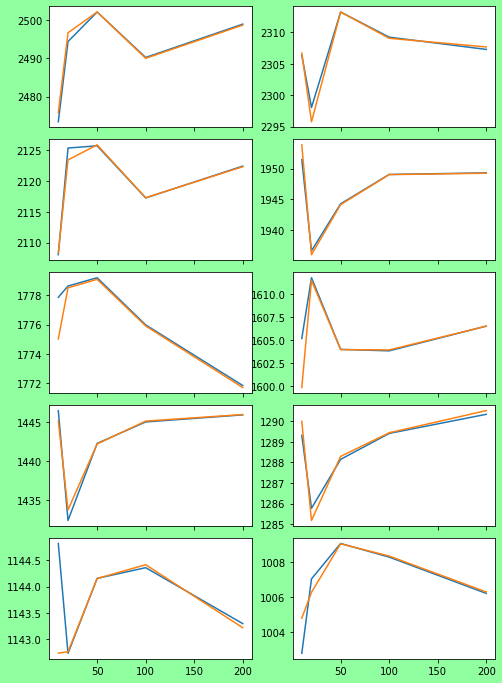

In [5]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec((num_categories + 1) // 2, 2, hspace=0.1, wspace=0.2)
ax = gs.subplots(sharex='col')
fig.patch.set_facecolor('xkcd:mint green')

for i in range(num_categories):
    c_ax = ax[i//2, i%2]
    c_ax.plot(num_train_list, stgp_mse[:, i].detach())
    c_ax.plot(num_train_list, lcegp_mse[:, i].detach())


It is possible that the MSE, with the baseline being the true test function, is not a
great metric to compare on. As an alternative, let's consider the true function as a
batch SingleTaskGP model, with each batch corresponding to a category. We will again
fit the two GP models on this and see how they compare.

In [11]:
def gen_baseline_gp(
    num_categories: int,
    num_train: int,
) -> SingleTaskGP:
    train_X = torch.rand(num_categories, num_train, 1)
    train_Y = torch.randn(num_categories, num_train, 1)
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model


def fit_models_on_baseline(
    baseline_model: SingleTaskGP,
    num_train: int,
    num_categories: int,
    options: dict = None,
) -> Tuple[SingleTaskGP, LCEGP]:
    options = options or dict()
    cat_X = torch.arange(0, num_categories, dtype=torch.float).view(-1, 1, 1)
    cont_X = torch.rand(num_categories, num_train, 1)

    train_Y = baseline_model.posterior(cont_X).mean.detach()

    stgp = SingleTaskGP(
        train_X=cont_X,
        train_Y=train_Y,
    )
    mll = ExactMarginalLogLikelihood(stgp.likelihood, stgp)
    fit_gpytorch_model(mll)

    train_X = torch.cat(
        [cat_X.expand(-1, num_train, -1), cont_X], dim=-1
    )

    lcegp = LCEGP(
        train_X=train_X.view(-1, 2),
        train_Y=train_Y.view(-1, 1),
        categorical_cols=[0],
        embs_dim_list=options.get("embds_dim_list", [2]),
    )
    mll = ExactMarginalLogLikelihood(lcegp.likelihood, lcegp)
    fit_gpytorch_model(mll)

    return stgp, lcegp


def calculate_mse_on_baseline(
    baseline_model: SingleTaskGP,
    num_test: int,
    num_categories: int,
    stgp: SingleTaskGP,
    lcegp: LCEGP,
) -> Tuple[Tensor, Tensor]:
    r"""
    Calculates the mean squared error of the predictive mean for the two
    given models.
    """
    cat_X = torch.arange(0, num_categories, dtype=torch.float).view(-1, 1, 1)
    cont_X = torch.linspace(0, 1, num_test).view(-1, 1)

    combined_X = torch.cat(
        [
            cat_X.expand(-1, num_test, -1), cont_X.expand(num_categories, -1, -1)
        ], dim=-1
    )

    true_values = baseline_model.posterior(cont_X).mean.squeeze(-1)
    stgp_values = stgp.posterior(cont_X).mean.squeeze(-1)
    lcegp_values = lcegp.posterior(combined_X).mean.squeeze(-1)

    stgp_mse = (stgp_values - true_values).pow(2).mean(dim=-1)
    lcegp_mse = (lcegp_values - true_values).pow(2).mean(dim=-1)
    return stgp_mse, lcegp_mse


def fit_and_get_mse_on_baseline(
    num_train: int,
    num_test: int,
    num_categories: int,
    options: dict = None
) -> Tuple[Tensor, Tensor]:
    r"""Combines the above three functions"""
    baseline = gen_baseline_gp(num_categories, num_train)
    stgp, lcegp = fit_models_on_baseline(
        baseline_model=baseline,
        num_train=num_train,
        num_categories=num_categories,
        options=options,
    )

    stgp_mse, lcegp_mse = calculate_mse_on_baseline(
        baseline_model=baseline,
        num_test=num_test,
        num_categories=num_categories,
        stgp=stgp,
        lcegp=lcegp,
    )

    return stgp_mse, lcegp_mse

In [12]:
num_categories = 10
replications = 5

num_train_list = [10, 20, 50, 100, 200]
stgp_mse = torch.zeros(len(num_train_list), num_categories)
lcegp_mse = torch.zeros(len(num_train_list), num_categories)
for i, num_train in enumerate(num_train_list):
    stgp_tmp = torch.zeros(replications, num_categories)
    lcegp_tmp = torch.zeros(replications, num_categories)
    for j in range(replications):
        stgp_tmp[j], lcegp_tmp[j] = fit_and_get_mse_on_baseline(
            num_train=num_train,
            num_test=1000,
            num_categories=num_categories,
            options={"embs_dim_list": [1]}
        )
    stgp_mse[i] = stgp_tmp.mean(dim=0)
    lcegp_mse[i] = lcegp_tmp.mean(dim=0)

/opt/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:311: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.01245541125535965 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:311: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.07052012532949448 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:311: N

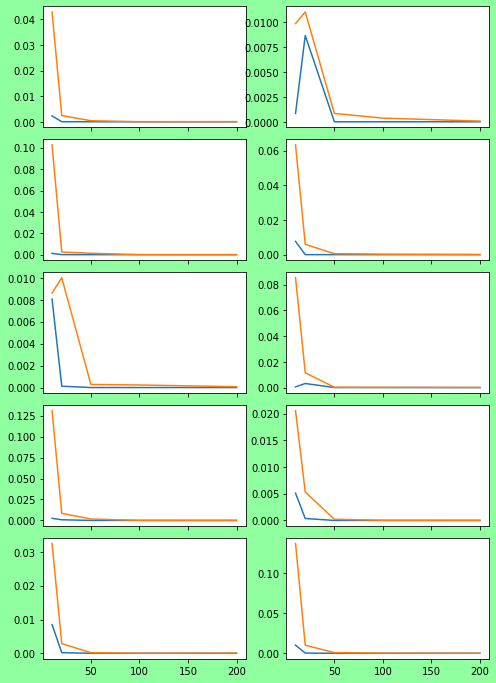

In [13]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec((num_categories + 1) // 2, 2, hspace=0.1, wspace=0.2)
ax = gs.subplots(sharex='col')
fig.patch.set_facecolor('xkcd:mint green')

for i in range(num_categories):
    c_ax = ax[i//2, i%2]
    c_ax.plot(num_train_list, stgp_mse[:, i].detach())
    c_ax.plot(num_train_list, lcegp_mse[:, i].detach())